# Squidpy integration

In this notebook, we will describe some usage principles for using SpatialData with squidpy.

Let's first import some useful libraries and read in a spatialdata dataset.

You might have to install squidpy with `!pip install squidpy`.

In [1]:
from pathlib import Path

import scanpy as sc
import spatialdata as sd
import spatialdata_plot
import squidpy as sq

We chosed a Xenium dataset formatted in the spatialdata format. 
You can download the data from here: [Xenium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip). Please rename the file to `xenium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [2]:
sdata = sd.read_zarr("xenium.zarr")
sdata

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/xenium_rep1_io/data.zarr
├── Images
│     ├── 'morphology_focus': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': DataTree[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (25778, 35416), (12889, 17708), (6444, 8854), (3222, 4427), (1611, 2213)
│     └── 'nucleus_labels': DataTree[yx] (25778, 35416), (12889, 17708), (6444, 8854), (3222, 4427), (1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'Shapes': GeoDataFrame shape: (2, 1) (2D shapes)
│     ├── 'Shapes_external': GeoDataFrame shape: (14, 1) (2D shapes)
│     ├── 'Shapes_external3': GeoDataFrame shape: (15, 1) (2D shapes)
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shap

SpatialData has a more complex structure than the (legacy) spatial `AnnData` format introduced by `squidpy`. Nevertheless, because it fundamentally uses `AnnData` as table for annotating regions, with some minor adjustments we can readily use any tool from the scverse ecosystem (`squidpy` included) to perform downstream analysis.

More precisely, the `scverse` ecosystem will gradually transition to use `SpatialData` internally; until that moment the function `to_legacy_anndata()` from `spatialdata_io.experimental` can be used to enrich the `AnnData` in `sdata.tables`  objects to be compatible with the legacy `AnnData` format.

Generally (i.e. when a single coordinate system is used), the only adjustment required is to populate `.obsm['spatial']` with the centroids of the geometries being considered, and this is performed automatically by the `spatialdata-io` library. For more complex cases, the converter functions `to_legacy_anndata()` and `from_legacy_anndata()` can be used (see example at the end of the notebook).

## Xenium example

As an example of integration with `Squidpy`, let's compute a nearest neighbor graph of the spatial coordiantes of the xenium dataset.

In [3]:
sq.gr.spatial_neighbors(sdata["table"])

After that, we can cluster the cells based on gene expression profiles and compute clustering.

In [4]:
%%time
sc.pp.pca(sdata["table"])
sc.pp.neighbors(sdata["table"])
sc.tl.leiden(sdata["table"])

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<timed exec>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


CPU times: user 1min 16s, sys: 1.86 s, total: 1min 18s
Wall time: 1min 20s


And run the neighbor enrichment analysis in squidpy.

100%|█████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.15/s]
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: divide by zero encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/opt/miniconda3/envs/ome/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step


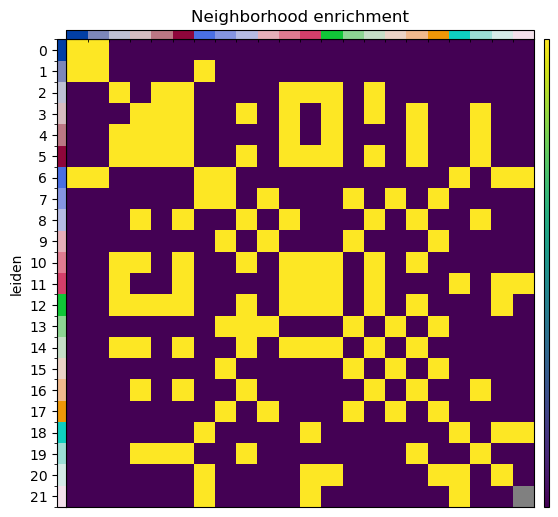

In [5]:
sq.gr.nhood_enrichment(sdata["table"], cluster_key="leiden")
sq.pl.nhood_enrichment(sdata["table"], cluster_key="leiden", figsize=(5, 5))

We can finally visualize the results in spatial coordinates both with squidpy as well as with the novel plotting function in spatialdata.


/opt/miniconda3/envs/ome/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


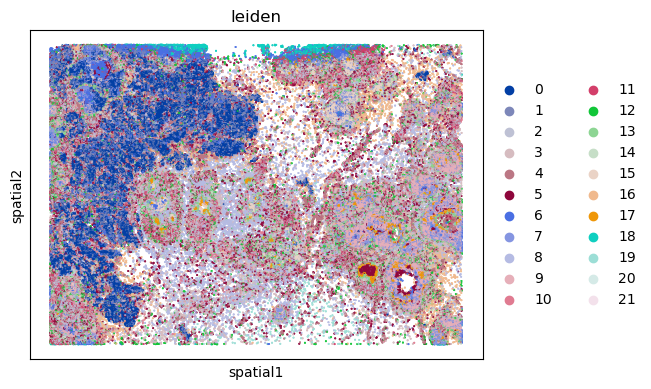

In [6]:
sq.pl.spatial_scatter(sdata["table"], shape=None, color="leiden")

/Users/macbook/embl/projects/basel/spatialdata-plot/src/spatialdata_plot/pl/utils.py:718: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


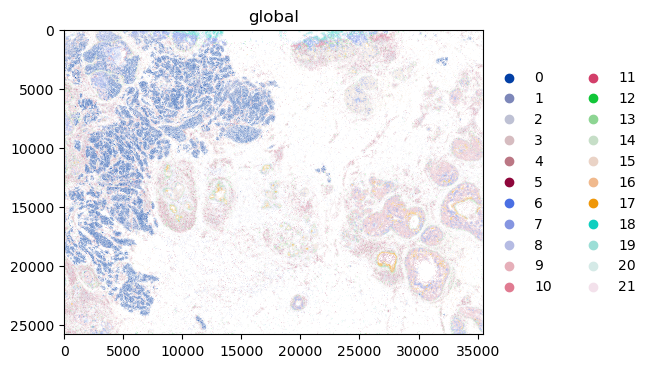

In [7]:
sdata.pl.render_shapes("cell_circles", color="leiden").pl.show(coordinate_systems="global")

## Using the converters from/to the legacy spatial `AnnData` format

We will now show how to convert from/to the legacy spatialdata `AnnData` format. The convertes deal with the complexity of having multiple libraries in the legacy format, and with the generality of coordinate systems in `SpatialData`. For more information please refer to the API documentation of `spatialdata-io`.

In [8]:
from typing import Literal

import matplotlib.pyplot as plt
import scanpy as sc
import spatialdata_io
import spatialdata_plot
import squidpy as sq
from anndata import AnnData
from spatialdata import SpatialData
from spatialdata._core.query.relational_query import get_element_instances
from spatialdata.datasets import blobs_annotating_element
from spatialdata.models import TableModel
from spatialdata.transformations import Affine, set_transformation
from spatialdata_io.experimental import from_legacy_anndata, to_legacy_anndata

BlobsTypes = Literal["blobs_labels", "blobs_circles", "blobs_polygons", "blobs_multipolygons"]


# def blobs_annotating_element(name: BlobsTypes) -> SpatialData:
#     """Returns toy data (blobs) with a table annotating the deised element."""
#     sdata = blobs(length=50)
#     instance_id = get_element_instances(sdata[name])
#     n = len(instance_id)
#     new_table = AnnData(shape=(n, 0), obs={"region": [name for _ in range(n)], "instance_id": instance_id})
#     new_table = TableModel.parse(new_table, region=name, region_key="region", instance_key="instance_id")
#     del sdata.tables["table"]
#     sdata["table"] = new_table
#     return sdata

### Example of conversion from the legacy AnnData to SpatialData

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


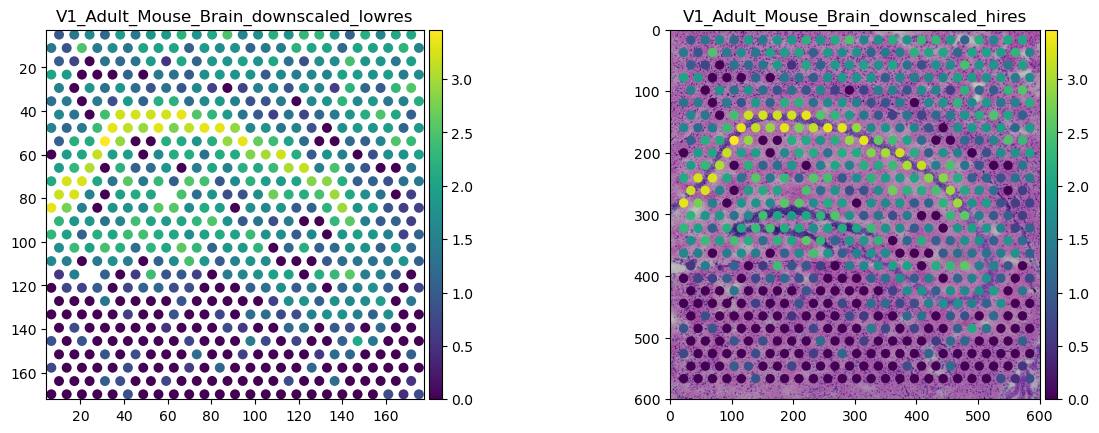

In [9]:
# some datasets you can play around with
# adata = sq.datasets.visium_fluo_adata()
# adata = sq.datasets.merfish()
adata = sq.datasets.visium_hne_adata_crop()

sdata = from_legacy_anndata(adata)

my_gene = "Itpka"
# broken (multiple table not yet supported in spatialdata-plot), this is being fix in https://github.com/scverse/spatialdata-plot/pull/220
sdata.pl.render_images("V1_Adult_Mouse_Brain_hires_image").pl.render_shapes(color=my_gene).pl.show()
plt.show()

### Example of conversion from SpatialData to the legacy AnnData, showing also that affine transformations are handled

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:246: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/datasets.py:366: UserWarning: Converting `region_key: region` to categorical dtype.
  new_table = TableModel.parse(new_table, region=name, region_key="region", instance_key="instance_id")


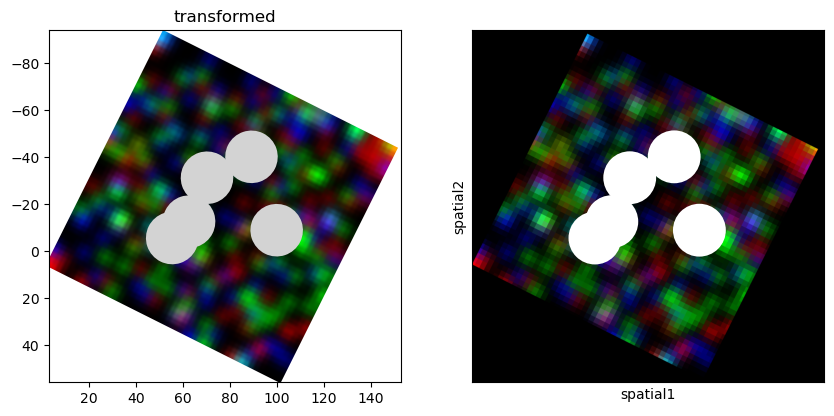

In [10]:
element = "blobs_circles"
sdata = blobs_annotating_element(element)
image = "blobs_multiscale_image"

affine = Affine([[1, 2, 3], [-2, 1, 6], [0, 0, 1]], input_axes=("x", "y"), output_axes=("x", "y"))
set_transformation(sdata[element], affine, "transformed")
set_transformation(sdata[image], affine, "transformed")

adata = to_legacy_anndata(sdata, include_images=True, coordinate_system="transformed")

axes = plt.subplots(1, 2, figsize=(10, 5))[1]
sdata.pl.render_images(image).pl.render_shapes(element).pl.show(coordinate_systems=["transformed"], ax=axes[0])
sc.pl.spatial(
    adata,
    spot_size=300,
    library_id=image,
    img_key="hires",
    na_color="white",
    show=True,
    crop_coord=(0, 2000, 0, 2000),
    ax=axes[1],
)